# Image compression

In [2]:
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 18})

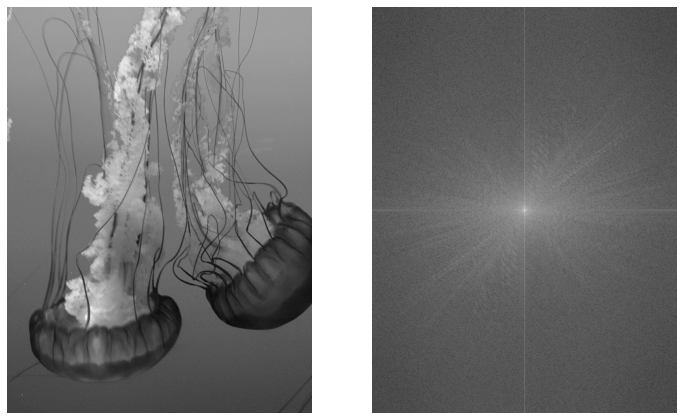

In [5]:
# Load data
A = imread(os.path.join('..','DATA','jelly.jpg'))
Abw = np.mean(A, -1); # Convert RGB to grayscale

## Compute FFT of image using fft2
At = np.fft.fft2(Abw)
F = np.log(np.abs(np.fft.fftshift(At))+1) # Put FFT on log scale

plt.subplot(1,2,1)
plt.imshow(Abw,cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(F,cmap='gray')
plt.axis('off')
plt.show()

plt.show()

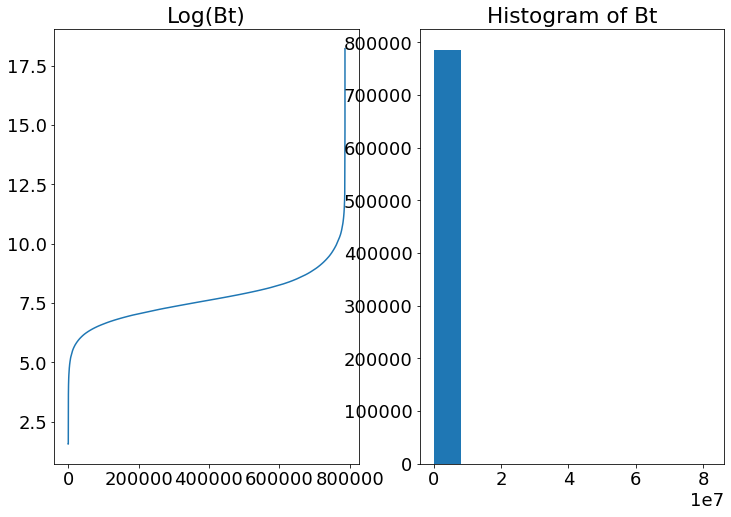

In [11]:
# Filter out all small coefficients
## Zero out all small coefficients and inverse transform
Bt = np.sort(np.abs(np.reshape(At,-1)))
plt.subplot(1,2,1)
plt.plot(np.log(Bt))
plt.title('Log(Bt)')
plt.subplot(1,2,2)
plt.hist(Bt)
plt.title('Histogram of Bt')
plt.show()

Threshold value 2007.70
Number of nonzero values is 393215 (original A has 786432)
Threshold value 8131.69
Number of nonzero values is 78643 (original A has 786432)
Threshold value 14589.59
Number of nonzero values is 39320 (original A has 786432)
Threshold value 44208.05
Number of nonzero values is 7863 (original A has 786432)
Threshold value 66662.01
Number of nonzero values is 3932 (original A has 786432)


<ipython-input-25-17a3b715987a>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  Alow = np.fft.ifft2(Atlow).astype('uint8')


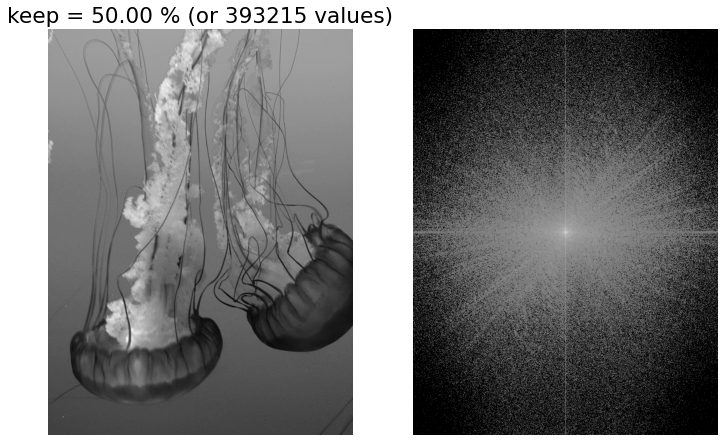

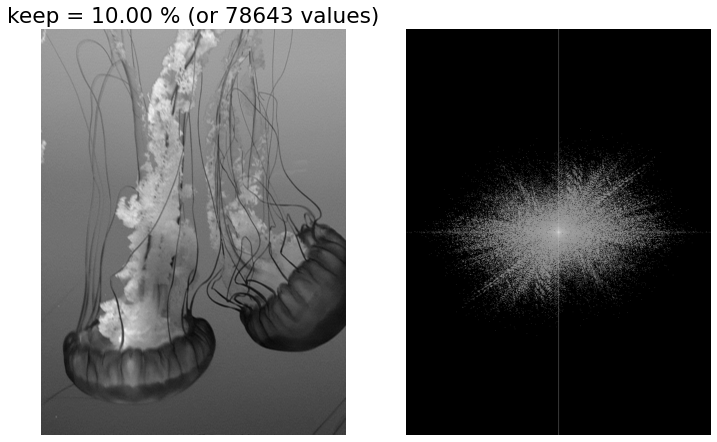

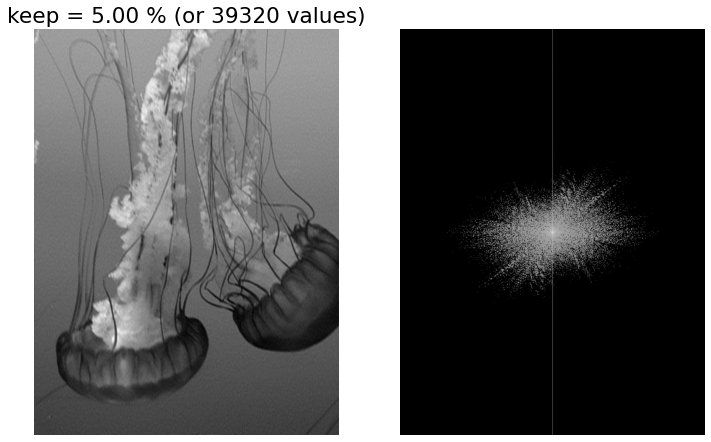

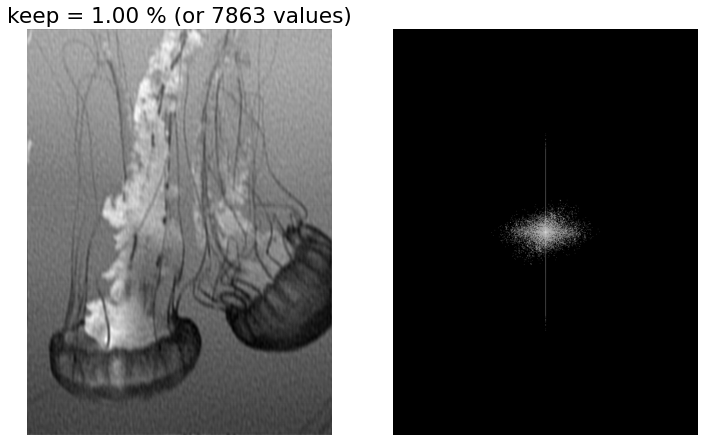

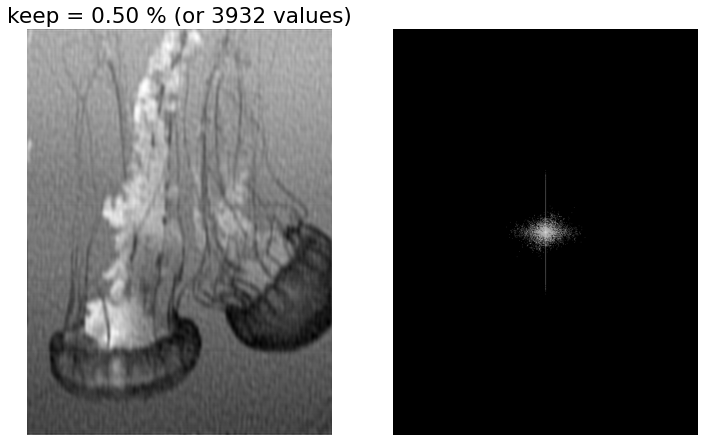

In [25]:
for keep in [0.5,0.1,0.05,0.01,0.005]:
    keep_ind = int(np.floor((1-keep)*len(Bt)))
    thresh = Bt[keep_ind]
    print('Threshold value {:.2f}'.format(thresh))
    ind = np.abs(At) > thresh
    print('Number of nonzero values is {0} (original A has {1})'.format(ind.sum(),1024*768))
    Atlow = At * ind
    Flow = np.log(np.abs(np.fft.fftshift(Atlow))+1) # Put FFT on log scale

    ## Plot Reconstruction
    Alow = np.fft.ifft2(Atlow).astype('uint8')

    plt.subplot(1,2,1)
    plt.imshow(Alow,cmap='gray')
    plt.axis('off')
    plt.title('keep = {0:.2f} % (or {1} values)'.format(keep*100,ind.sum()))
    plt.subplot(1,2,2)
    plt.imshow(Flow,cmap='gray')
    plt.axis('off')
    plt.show()

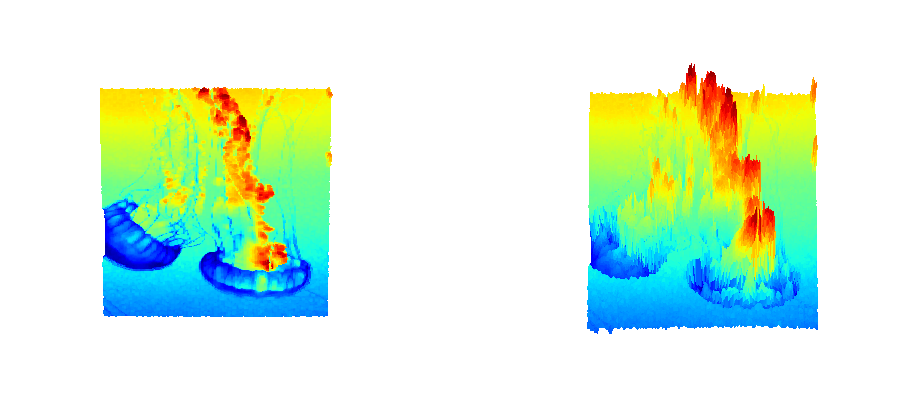

In [6]:
plt.rcParams['figure.figsize'] = [16, 8]

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

Anew = Abw[::5,::5]

y = np.arange(Anew.shape[0])
x = np.arange(Anew.shape[1])

X,Y = np.meshgrid(x,y)

surf1 = ax1.plot_surface(X,Y,Anew, rstride=1, cstride=1,cmap='jet',
                       linewidth=1, antialiased=False)
surf2 = ax2.plot_surface(X,Y,Anew, rstride=1, cstride=1,cmap='jet',
                       linewidth=1, antialiased=False)

ax1.view_init(90, 90)
ax1.axis('off')

ax2.view_init(60, 90)
ax2.axis('off')

plt.show()

# Sparse

# Solve $y = \Theta  s$ for $s$

In [27]:
from scipy.optimize import minimize
plt.rcParams['figure.figsize'] = [12, 18]
plt.rcParams.update({'font.size': 18})

In [30]:
# Solve y = Theta * s for "s"
n = 1000 # dimension of s
p = 200  # number of measurements, dim(y)
# Generate random Theta and y
Theta = np.random.randn(p,n)
y = np.random.randn(p)
Theta[:5,:5], y[:5]

(array([[-0.9416359 ,  0.02157489, -1.81214896, -0.05189879,  1.43002821],
        [ 0.06769684, -0.09851567,  0.82573493, -0.63499709, -0.61095012],
        [-0.96740535, -2.39148282, -1.48577773, -0.23678348,  0.13710256],
        [-0.06319192, -0.61053495, -0.94288288,  0.09465421,  1.31328825],
        [ 0.11965662, -2.09514011, -0.20560574, -0.66347253, -1.29908723]]),
 array([-0.27601797, -0.46878828,  0.39480195,  1.14986658, -0.94938627]))

In [31]:
# L1 Minimum norm solution s_L1
# In Python norm with ord = 1 is L1
def L1_norm(s):
    return np.linalg.norm(s,ord=1)

constr = ({'type': 'eq', 'fun': lambda s:  Theta @ s - y})
# pinv function: Compute the (Moore-Penrose) pseudo-inverse of a matrix.
s0 = np.linalg.pinv(Theta) @ y # initialize with L2 solution

In [32]:
%%time
# Minimize function: Minimization of scalar function of one or more variables
# Sequential Least Squares Programming (SLSQP)
print('It tokes around 2.5 min')
res = minimize(L1_norm, s0, method='SLSQP',constraints=constr)

Wall time: 2min 24s


<ipython-input-33-0fd56733212d>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  axs[0].plot(s_L1,color='b',LineWidth=1.5)
<ipython-input-33-0fd56733212d>:12: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  axs[1].plot(s_L2,color='r',LineWidth=1.5)


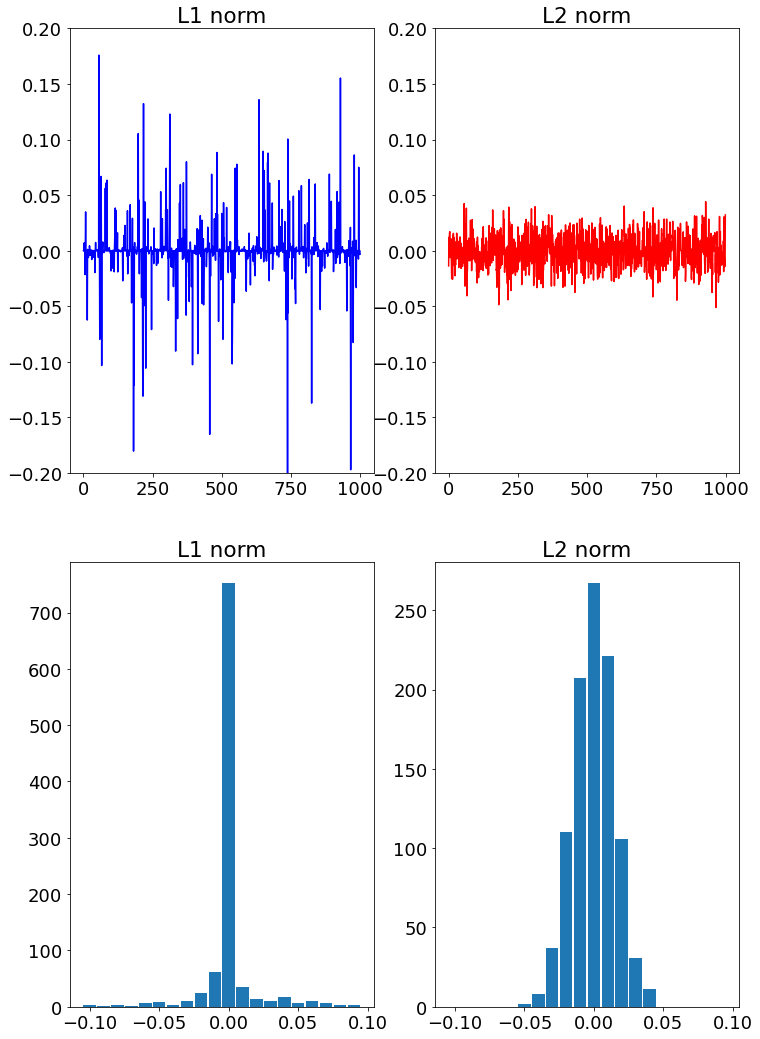

In [33]:
# Res:The optimization result represented as a OptimizeResult object
# Attribute x is the solution of the optimization (array).
s_L1 = res.x
s_L2 = s0

# Visualization
fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)
axs[0].plot(s_L1,color='b',LineWidth=1.5)
axs[0].set_ylim(-0.2,0.2)
axs[0].set_title('L1 norm')
axs[1].plot(s_L2,color='r',LineWidth=1.5)
axs[1].set_ylim(-0.2,0.2)
axs[1].set_title('L2 norm')
axs[2].hist(s_L1,bins=np.arange(-0.105,0.105,0.01),rwidth=0.9)
axs[2].set_title('L1 norm')
axs[3].hist(s_L2,bins=np.arange(-0.105,0.105,0.01),rwidth=0.9)
axs[3].set_title('L2 norm')

plt.show()

(508, 24)

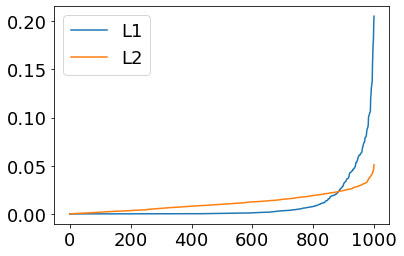

In [43]:
plt.figure(figsize=(6,4))
plt.plot(np.sort(np.abs(s_L1)),label = 'L1')
plt.plot(np.sort(np.abs(s_L2)),label = 'L2')
plt.legend()
thresh = 0.0005
(np.abs(s_L1)<thresh).sum(), (np.abs(s_L2)<thresh).sum()